In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import  Input, dot, concatenate
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM

import gc
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_rows',50)
pd.set_option('display.max_columns', 50)

In [11]:
info = pd.read_csv('../datasets/ml-100k/u.info' , sep=" ", header = None)
info.columns = ['Counts' , 'Type']

occupation = pd.read_csv('../datasets/ml-100k/u.occupation' , header = None)
occupation.columns = ['Occupations']

items = pd.read_csv('../datasets/ml-100k/u.item' , header = None , sep = "|" , encoding='latin-1')
items.columns = ['movie id' , 'movie title' , 'release date' , 'video release date' ,
              'IMDb URL' , 'unknown' , 'Action' , 'Adventure' , 'Animation' ,
              'Childrens' , 'Comedy' , 'Crime' , 'Documentary' , 'Drama' , 'Fantasy' ,
              'Film_Noir' , 'Horror' , 'Musical' , 'Mystery' , 'Romance' , 'Sci_Fi' ,
              'Thriller' , 'War' , 'Western']

data = pd.read_csv('../datasets/ml-100k/u.data', header= None , sep = '\t')
user = pd.read_csv('../datasets/ml-100k/u.user', header= None , sep = '|')
genre = pd.read_csv('../datasets/ml-100k/u.genre', header= None , sep = '|' )

genre.columns = ['Genre' , 'genre_id']
data.columns = ['user id' , 'movie id' , 'rating' , 'timestamp']
user.columns = ['user id' , 'age' , 'gender' , 'occupation' , 'zip code']


In [12]:
display(info)
display(user.shape)
display(items.shape)
display(data.shape)

,Counts,Type
0,943,users
1,1682,items
2,100000,ratings


(943, 5)

(1682, 24)

(100000, 4)

In [13]:
# Merging the columns with data table to better visualise
data = data.merge(user , on='user id')
data = data.merge(items , on='movie id')

data.head()

,user id,movie id,rating,timestamp,age,gender,occupation,zip code,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,196,242,3,881250949,49,M,writer,55105,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,305,242,5,886307828,23,M,programmer,94086,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,242,4,883268170,42,M,executive,98101,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,234,242,4,891033261,60,M,retired,94702,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,63,242,3,875747190,31,M,marketing,75240,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
# Data Cleaning for Model Based Recommandation System
def convert_time(x):
    return datetime.utcfromtimestamp(x).strftime('%d-%m-%Y')

def date_diff(date):
    d1 = date['release date'].split('-')[2]
    d2 = date['rating time'].split('-')[2]
    return abs(int(d2) - int(d1))

# data.drop(columns = ['movie title' , 'video release date' , 'IMDb URL'] , inplace = True)
data.dropna(subset = ['release date'] , inplace = True)

# add number of ratings per user
user_details = data.groupby('user id').size().reset_index()
user_details.columns = ['user id' , 'number of user ratings']
data = data.merge(user_details , on='user id')

# add number of ratings movie
movie_details = data.groupby('movie id').size().reset_index()
movie_details.columns = ['movie id' , 'number of movie ratings']
data = data.merge(movie_details , on='movie id')

# add average of ratings per user
user_details = data.groupby('user id')['rating'].agg('mean').reset_index()
user_details.columns = ['user id' , 'average of user ratings']
data = data.merge(user_details , on='user id')

# add average of ratings per movie
movie_details = data.groupby('movie id')['rating'].agg('mean').reset_index()
movie_details.columns = ['movie id' , 'average of movie ratings']
data = data.merge(movie_details , on='movie id')

# add standard deviation of ratings per user
user_details = data.groupby('user id')['rating'].agg('std').reset_index()
user_details.columns = ['user id' , 'std of user ratings']
data = data.merge(user_details , on='user id')

# add standard deviation of ratings per movie
movie_details = data.groupby('movie id')['rating'].agg('std').reset_index()
movie_details.columns = ['movie id' , 'std of movie ratings']
data = data.merge(movie_details , on='movie id')

# add age group
data['age_group'] = data['age']//10

# add release year
data['rating time'] = data.timestamp.apply(convert_time)
data['time difference'] = data[['release date' , 'rating time']].apply(date_diff, axis =1)

# add total rating
data['total rating'] = (data['number of user ratings']*data['average of user ratings'] + data['number of movie ratings']*data['average of movie ratings'])/(data['number of movie ratings']+data['number of user ratings'])
data['rating_new'] = data['rating'] - data['total rating']

del movie_details
del user_details
gc.collect()

data.head()

,user id,movie id,rating,timestamp,age,gender,occupation,zip code,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,number of user ratings,number of movie ratings,average of user ratings,average of movie ratings,std of user ratings,std of movie ratings,age_group,rating time,time difference,total rating,rating_new
0,196,242,3,881250949,49,M,writer,55105,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,39,117,3.615385,3.991453,1.016065,0.995643,4,04-12-1997,0,3.897436,-0.897436
1,305,242,5,886307828,23,M,programmer,94086,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,222,117,3.409910,3.991453,1.079840,0.995643,2,01-02-1998,1,3.610619,1.389381
2,6,242,4,883268170,42,M,executive,98101,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,211,117,3.635071,3.991453,1.039461,0.995643,4,28-12-1997,0,3.762195,0.237805
3,234,242,4,891033261,60,M,retired,94702,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,480,117,3.122917,3.991453,0.920366,0.995643,6,27-03-1998,1,3.293132,0.706868
4,63,242,3,875747190,31,M,marketing,75240,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,93,117,3.118280,3.991453,0.987415,0.995643,3,01-10-1997,0,3.604762,-0.604762


# Matrix Factorization with Keras

In [21]:
data = data.sample(frac = 1) # shuffling the data
data_train_x = np.array(data[['user id' , 'movie id']].values)
data_train_y = np.array(data['rating'].values)
x_train, x_test, y_train, y_test = train_test_split(data_train_x, data_train_y, test_size = 0.2, random_state = 98)
n_factors = 50
n_users = data['user id'].max()
n_movies = data['movie id'].max()


In [22]:
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = n_users+1, output_dim=n_factors, input_length=1,name='User_Embedding')(user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)

movie_input = Input(shape = (1,) , name = 'Movie_input')
movie_embeddings = Embedding(input_dim = n_movies+1 , output_dim = n_factors , input_length = 1 , name = 'Movie_Embedding')(movie_input)
movie_vector = Flatten(name = 'Movie_Vector')(movie_embeddings)

merged_vectors = concatenate([user_vector, movie_vector], name='Concatenation')
dense_layer_1 = Dense(100 , activation = 'relu')(merged_vectors)
dense_layer_3 = Dropout(.5)(dense_layer_1)
dense_layer_2 = Dense(1)(dense_layer_3)
model = Model([user_input, movie_input], dense_layer_2)

In [23]:
model.compile(loss='mean_squared_error', optimizer='adam' ,metrics = ["mean_squared_error"] )
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User_Embedding (Embedding)     (None, 1, 50)        47200       ['User_Input[0][0]']             
                                                                                                  
 Movie_Embedding (Embedding)    (None, 1, 50)        84150       ['Movie_input[0][0]']            
                                                                                            

In [24]:
history = model.fit(x = [x_train[:,0] , x_train[:,1]] , y =y_train , batch_size = 128 , epochs = 15 , validation_data = ([x_test[:,0] , x_test[:,1]] , y_test))

Epoch 1/15
625/625 [==============================] - 4s 4ms/step - loss: 2.1301 - mean_squared_error: 2.1301 - val_loss: 0.9330 - val_mean_squared_error: 0.9330
Epoch 2/15
625/625 [==============================] - 2s 4ms/step - loss: 1.1048 - mean_squared_error: 1.1048 - val_loss: 0.9090 - val_mean_squared_error: 0.9090
Epoch 3/15
625/625 [==============================] - 3s 4ms/step - loss: 1.0733 - mean_squared_error: 1.0733 - val_loss: 0.8999 - val_mean_squared_error: 0.8999
Epoch 4/15
625/625 [==============================] - 2s 3ms/step - loss: 1.0535 - mean_squared_error: 1.0535 - val_loss: 0.8905 - val_mean_squared_error: 0.8905
Epoch 5/15
625/625 [==============================] - 2s 3ms/step - loss: 1.0320 - mean_squared_error: 1.0320 - val_loss: 0.8885 - val_mean_squared_error: 0.8885
Epoch 6/15
625/625 [==============================] - 2s 3ms/step - loss: 1.0173 - mean_squared_error: 1.0173 - val_loss: 0.8895 - val_mean_squared_error: 0.8895
Epoch 7/15
625/625 [========

In [25]:
loss , val_loss , accuracy , val_accuracy = history.history['loss'],history.history['val_loss'],history.history['mean_squared_error'],history.history['val_mean_squared_error']

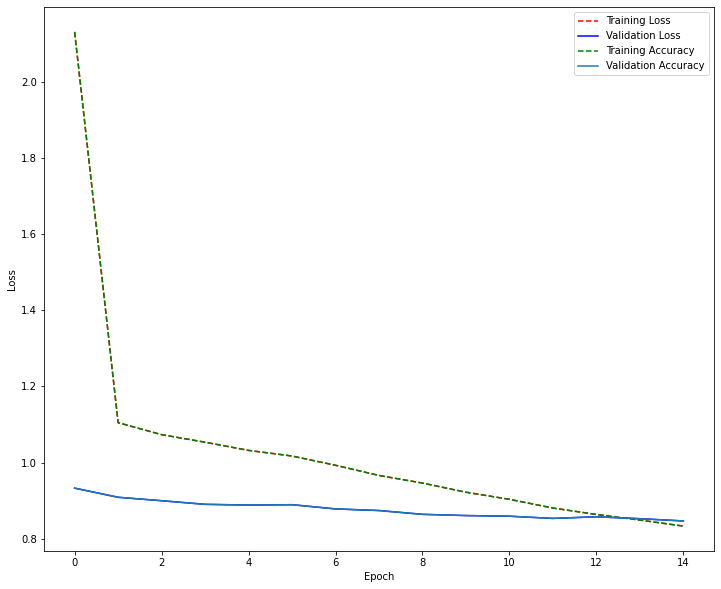

In [26]:
plt.figure(figsize = (12,10))
plt.plot( loss, 'r--')
plt.plot(val_loss, 'b-')
plt.plot( accuracy, 'g--')
plt.plot(val_accuracy,'-')
plt.legend(['Training Loss', 'Validation Loss' , 'Training Accuracy' , 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [28]:
score = model.evaluate([x_test[:,0], x_test[:,1]], y_test)
print(np.sqrt(score)[0])

625/625 [==============================] - 1s 2ms/step - loss: 0.8469 - mean_squared_error: 0.8469
0.9202862643532385


In [29]:
#prediction
pred = model.predict([x_test[:,0], x_test[:,1]])


625/625 [==============================] - 1s 2ms/step


In [38]:
#let userID = 673 and movieID's be IDS of movie_list = ["Game, The (1997)", "Jackie Brown (1997)", "Lost Highway (1997)", "Alien: Resurrection (1997)", "As Good As It Gets (1997)", "Mrs. Brown (Her Majesty, Mrs. Brown) (1997)", "U Turn (1997)", "Evita (1996)", "Game, The (1997)", "Volcano (1997)"]

user_id = 673
movie_list = ["Game, The (1997)", "Jackie Brown (1997)", "Lost Highway (1997)", "Alien: Resurrection (1997)", "As Good As It Gets (1997)", "Mrs. Brown (Her Majesty, Mrs. Brown) (1997)", "U Turn (1997)", "Evita (1996)", "Game, The (1997)", "Volcano (1997)"]
# find movie id's
movie_ids = []
for movie in movie_list:
    id = items[items['movie title'] == movie]['movie id'].values[0]
    movie_ids.append(id)

ratings = []
for movie_id in movie_ids:
    ratings.append(model.predict([np.array([user_id]), np.array([movie_id])])[0][0])

print(ratings)

1/1 [==============================] - 0s 29ms/step
[3.7342758, 3.8315904, 3.28018, 3.5231757, 4.244693, 4.076888, 3.5256, 3.3188994, 3.7342758, 2.8005986]


In [41]:
#choose a random movie id for the user
movie_id = 456
print(model.predict([np.array([user_id]), np.array([movie_id])])[0][0])

1/1 [==============================] - 0s 32ms/step
2.4082172
